# Modelling NBA career stats

So we've got all active player stats (which met our arbitrary playtime requirement) from the 2021-22 season. Let's use an unsupervised learning model to cluster them and reveal which groups there are.

I expect features like playtime, fga, and 3pa will be important contributors to determining which cluster a player belongs to.

## EDA

Load data and run some prelim analytics and visuals

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

fp = "../data/nba_stats.pkl"
# requires boto3, fsspec, and probably a whole host of other dependencies
# fp = "s3://streamlit-demo-93/data/cleaned/nba_stats.pkl"
df = pd.read_pickle(fp)
df.head()

,FGA,FG_PCT,FG3A,FG3_PCT,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
PLAYER_ID,,,,,,,,,,,,,,,
1630173,12.402353,0.444929,3.328235,0.352506,2.629412,0.595706,2.816471,6.475294,9.391765,1.643529,0.715294,0.928235,1.814118,3.171765,13.801176
203500,6.853333,0.528644,0.000000,0.000000,3.584444,0.543311,6.051111,7.726667,13.777778,4.615556,1.060000,0.975556,1.975556,2.955556,9.204444
1628389,12.795652,0.571478,0.100000,0.000000,5.839130,0.756913,2.504348,7.578261,10.043478,3.347826,1.404348,0.860870,2.626087,3.321739,18.947826
200746,16.204918,0.528197,1.600000,0.296885,3.821311,0.860377,2.568852,6.483607,9.052459,1.721311,0.545902,1.462295,1.385246,2.791803,20.777049
1629638,16.661194,0.390746,8.052239,0.301716,2.849254,0.750672,0.873134,3.819403,4.692537,3.916418,1.297015,0.582090,2.231343,2.425373,17.638806


Should remove `REB` since it's simply sum of OREB and DREB. Already removed other collinear features in FGM, FG3M, and FTM, but I missed this one.

Start with something a little silly. Does FGA correlate with TOV? Let's use a heatmap to visualize the correlation matrix

In [2]:
def heatmap(
    data, row_labels, col_labels, ax=None, cbar_kw=None, cbarlabel="", **kwargs
):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right", rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1] + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0] + 1) - 0.5, minor=True)
    ax.grid(which="minor", color="w", linestyle="-", linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(
    im,
    data=None,
    valfmt="{x:.2f}",
    textcolors=("black", "white"),
    threshold=None,
    **textkw
):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max()) / 2.0

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center", verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

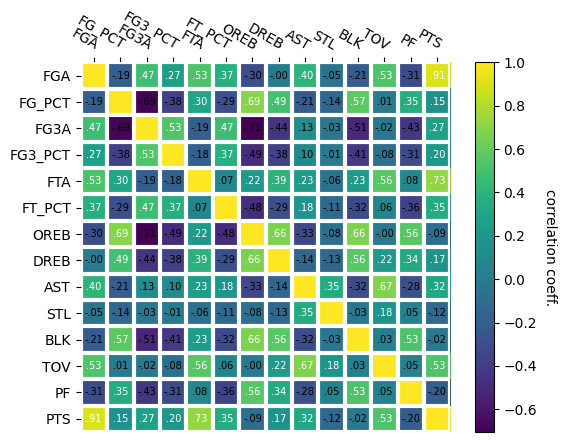

In [3]:
df = df.drop("REB", axis=1)
corr_mat = np.corrcoef(
    df.to_numpy(),
    rowvar=False,
)

stat_labels = list(df.columns)
im, _ = heatmap(corr_mat, stat_labels, stat_labels, cbarlabel="correlation coeff.")


def func(x, pos):
    return "{:.2f}".format(x).replace("0.", ".").replace("1.00", "")


annotate_heatmap(im, valfmt=mpl.ticker.FuncFormatter(func), size=7)

plt.show()

Cool beans. Some obvious observations:

1. Blocks are inverse to FG3A, 
1. PTS almost completely linear with FGA, 
1. FT_PCT inverse with REB. Hellooo hack-a-shaq

Some a little more nuanced:

1. AST and FGA? With the rise of do-it-all point guards this makes a lot of sense, e.g. Harden, Westbrook, Dame
1. There are these *groups* of features that almost act like one:
    * FG3A, FG3_PCT, and FT_PCT
    * DREB/OREB, *BLK*, and *PF*

    
Looks like we're already seeing some clear divisions just from the map

## Feature engineering

Besides dropping the collinear-by-design features, we could implement some advanced stats based on our basic boxscore, such as

* effective fg% and true shooting %
* Usage %
* OFFRTG/DEFRTG

But let's stick to basics for this streamlit demo

## Model

Most unsupervised learning models employ some sort of distance-between-points metric for determining which cluster a point should belong to. K-means, hierarchical, and DBSCAN comes to mind. 

The assumption here is that we do *not* know beforehand how many groups there are, and are relying on the mentioned clustering techniques to find that out for us. Even though KMeans require *n_cluster* be specified, that would be a hyperparameter to be tuned.

With all clustering, there is no guarantee of recovering the ground truth, and even choosing the initial parameters for *n_cluster* is nontrivial

### Evaluating clustering performance

If we don't know the target ourselves, how would we evaluate model results? Ideally we'd want our clustering to reveal some ground truths, some clearly defined separations between the sample points. Members in the same class should be more similar than members of a different class.

Here are a few metrics when the ground truths of sample classes *are not known*:

1. Silhouette coefficient - higher = more defined clusters. 
    * Compares distances between in-members and out-members
    * Normalized from -1 to 1. 
    * Prefers convex clusters over non-traditional shapes
    * `sklearn.metrics.silhouette_score`
1. Calinski-Harabasz index, aka Variance Ratio Criterion
    * higher = better defined clusters
    * index is ratio of between-cluster dispersion and in-cluster dispersion
    * dispersion is a compiled metric based on point distances
    * Also prefers convex clusters, which is not favourable to density-based clustering e.g. DBSCAN
    * `sklearn.metrics.calinski_harabasz_score`
1. Davies-Bouldin index
    * Index is the average *similarity* between clusters
    * similarity compares distance between cluster and the size of clusters
    * zero is the best and lowest score, indicating good partition
    * `sklearn.metrics.davies_bouldin_score`

### K-means

Intuitively easy to understand, and scales easily to large number of samples. Requires that we specify the number of clusters to begin with. Idea is that it separates samples into $n$ groups of equal variance, by minimizing *within-cluster sum of squares*. Each cluster will have a *centroid* around which all points in that cluster gathers, though the centroid is not necessarily one of the points.

The *within-cluster SSQ* is also known as *inertia*, and can be intuitively understood as *how internally coherent* the clusters are. 

Drawbacks of inertia as metric:

1. Assumes clusters are convex or isotropic. Deals poorly with elongated clusters, or irregular shapes
1. Not a normalized metric. Generally we just know lower is better and zero is best. 
1. Relies on Euclidean distances, which suffers from curse of dimensionality in many-feature datasets. PCA alleviates this.

Algorithm starts by initializing some centroid positions, and iterating until convergence, where inertia is some low enough value, and improvements plateau.

Since we need to define *n_clusters* prior to fitting, let's think about this for a sec. How many player archetypes should there be?

1. Stars - high FGA, high PTS; could there be a sub-division via FG_PCT?
1. Centers - high REB/FG_PCT, low FT_PCT? 
1. Shooters - high 3PA/3P_PCT/FT_PCT
1. Role players - low FGA/3PA, low PTS. These could also encompass defensive specialists

We'll center our *n_clusters* around 4, but rely on kmeans++ to initialize.

In [2]:
from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

N_CLUSTERS = 4

knn_pipe = make_pipeline(
    StandardScaler(),
    PCA(n_components=2),
    cluster.KMeans(
        n_clusters=N_CLUSTERS,
        init="k-means++",
    ),
)

knn_pipe.fit(df)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('kmeans', KMeans(n_clusters=4))])

In [72]:
knn_pipe["pca"].explained_variance_ratio_

array([0.34089276, 0.23364861])

In [3]:
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)


def score_cluster(
    cluster,
    data,
    printout=False,
) -> list[int]:
    """Evalutes cluster performance

    Parameters
    ----------
    cluster
        fitted cluster with `.labels_` attribute
    data
        A 2D numpy array or pandas dataframe of shape (M, N).

    Returns
    -------
    scores
        list of cluster evaluation scores (float)
    """
    silh = silhouette_score(data, labels=cluster.labels_, metric="euclidean")
    ch = calinski_harabasz_score(data, labels=cluster.labels_)
    db = davies_bouldin_score(data, labels=cluster.labels_)

    if printout:

        print(f"silhouette_score:\t\t{silh:.3f}")
        print(f"calinski_harabasz_score:\t{ch:.3f}")
        print(f"davies_bouldin_score:\t\t{db:.3f}")
    return silh, ch, db

In [4]:
knn_scores = score_cluster(knn_pipe[-1], df, printout=True)

silhouette_score:		0.167
calinski_harabasz_score:	136.422
davies_bouldin_score:		1.615


* positive silhouette score indicates correct clustering, but proximity to zero indicates *overlapping*
* c_h score seems high? should indicate clear definition of clusters, but seems contrary to silhouette
* d_b is best at zero, but I'm unsure what the scale is. Only meaningful when comparing to other models, like c_h

In [75]:
def pca_plot(pipe, X):
    # last step in pipeline is the clustering
    y_pred = pipe[-1].labels_
    # every step until the last transforms the input
    X_r = pipe[:-1].transform(X)

    # # assumes the PCA is part of pipeline
    # print(
    #     f"explained var ratio of first two comp: {pipe['pca'].explained_variance_ratio_}"
    # )

    plt.figure()
    colors = ["navy", "turquoise", "darkorange", "green"]
    lw = 2
    for color, i in zip(colors, range(4)):
        plt.scatter(
            X_r[y_pred == i, 0],
            X_r[y_pred == i, 1],
            color=color,
            alpha=0.8,
            lw=lw,
            label=i,
        )
    plt.legend(loc="best", shadow=False, scatterpoints=1)

    clusterer_name = list(pipe.named_steps.keys())[-1]
    plt.title(f"{clusterer_name}: PCA of NBA career stats (n_comp=2)")
    plt.show()

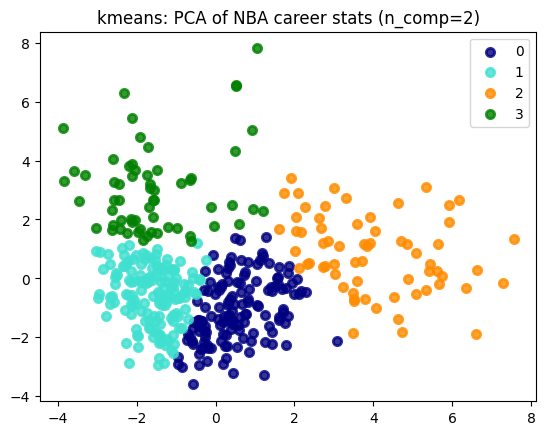

In [76]:
pca_plot(knn_pipe, df)

### Hierarchical

Family of clustering algorithms that build nested clusters either by merging (bottom up) or dividing (top down) successively. Called hierarchical because of the tree root branching out representation; root is a cluster containing all samples; leaves being clusters with only one.

`AgglomerativeClustering` performs bottom-up clustering, starting with each sample as its own cluster, and forming links to nearby points via one of the following strategies:

1. Ward - similar idea to Kmeans where it minimizes SSQ diff between points.
    * Tends to give most regular sizes
1. Max/complete linkage - minimzes the max distance between obs of pairs of clusters???
1. Avg linkage - minimizes the *average* distance.
    * Allowed to use non-euclidean distances
1. Single linkage - minimizes the distance between the closest observations of pairs of clusters

Scalable to large datasets, if *connectivity constraints* are added, i.e. only adjacent clusters can be merged

In [77]:
hw_pipe = make_pipeline(
    StandardScaler(),
    PCA(n_components=2),
    cluster.AgglomerativeClustering(
        n_clusters=N_CLUSTERS,
    ),
)

hw_pipe.fit(df)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('agglomerativeclustering',
                 AgglomerativeClustering(n_clusters=4))])

In [78]:
score_cluster(hw_pipe["agglomerativeclustering"], df, True)

silhouette_score:		0.177
calinski_harabasz_score:	136.768
davies_bouldin_score:		1.492


(0.17723042877555337, 136.76788676624295, 1.4919381170056467)

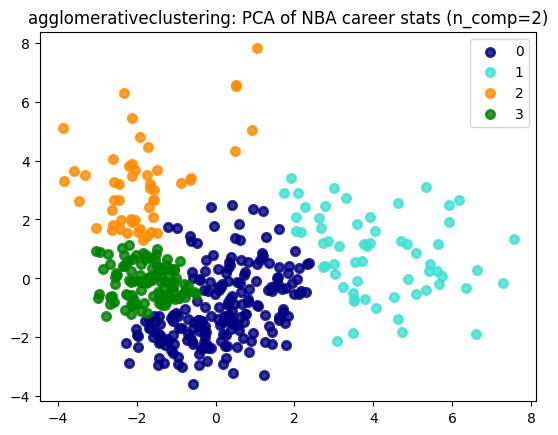

In [79]:
pca_plot(hw_pipe, df)

### DBSCAN

Looks for dense clusters vs sparse areas. The broader view allows non-traditional shapes to be collected as a cluster, vs Kmeans which prefers traditional convex shapes.

DBSCAN looks for *core samples*, which are points in the density center of the clusters. Two parameters define the concept of density:

1. `min_samples`
1. `eps`

Core sample is defined as a sample in dataset that there exist `min_samples` neighboring points within distance `eps`. A cluster is iteratively built by finding all neighbors of one core sample, and finding neighbors of those that are also core samples. Eventually we would find some neighbors which cannot be defined as core samples because they do not have sufficient neighbors; those are intuitively thought as the fringes of the cluster.


In [68]:
db_pipe = make_pipeline(
    StandardScaler(),
    PCA(n_components=2),
    cluster.DBSCAN(),
)

db_pipe.fit(df)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)), ('dbscan', DBSCAN())])

In [69]:
score_cluster(db_pipe["dbscan"], df, True)

silhouette_score:		0.011
calinski_harabasz_score:	28.863
davies_bouldin_score:		2.018


(0.011176047287614304, 28.86308169530492, 2.017655406853102)

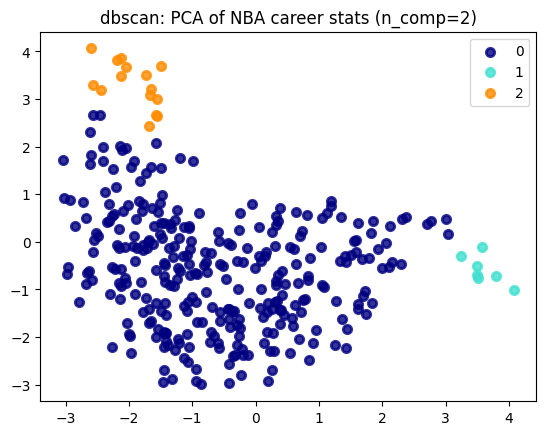

In [70]:
pca_plot(db_pipe, df)

Hmm. That's less than inspiring.

No matter, we'll include more params in our search space and log it to MLflow